In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import RandomUnderSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, mean_absolute_error
from sklearn.tree import plot_tree, DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

In [33]:
# Load files into a pandas dataframe
df = pd.read_csv('data/Train.csv')
# Let’s observe the shape of our datasets.
print('train data shape :', df.shape)
# inspect train data
df.head()

train data shape : (23524, 13)


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [34]:
# drop columns I don't need for my model
df.drop('year', axis=1, inplace=True)
df.drop('uniqueid', axis=1, inplace=True)
df.head()

,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [35]:
df.columns

Index(['country', 'bank_account', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   bank_account            23524 non-null  object
 2   location_type           23524 non-null  object
 3   cellphone_access        23524 non-null  object
 4   household_size          23524 non-null  int64 
 5   age_of_respondent       23524 non-null  int64 
 6   gender_of_respondent    23524 non-null  object
 7   relationship_with_head  23524 non-null  object
 8   marital_status          23524 non-null  object
 9   education_level         23524 non-null  object
 10  job_type                23524 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.0+ MB


In [37]:
df.columns

Index(['country', 'bank_account', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

In [38]:
df['bank_account'] = df['bank_account'].map({'No': 0, 'Yes': 1})
df['location_type'] = df['location_type'].map({'Rural': 0, 'Urban': 1})
df.columns = df.columns.str.replace('location_type','Urban_location')
df['cellphone_access'] = df['cellphone_access'].map({'No': 0, 'Yes': 1})
df['gender_of_respondent'] = df['gender_of_respondent'].map({'Male': 0, 'Female': 1})

df['country'] =  df['country'].map({'Kenya':0, 'Rwanda':1, 'Tanzania':2, 'Uganda':3})

df['relationship_with_head']=df['relationship_with_head'].map({'Spouse':0,
                                                            'Head of Household':1,
                                                            'Other relative':2,
                                                            'Child':3,
                                                            'Parent':4,
                                                            'Other non-relatives':5})

df['marital_status'] =df['marital_status'].map({'Married/Living together':0,
                                                'Widowed':1,
                                                'Single/Never Married':2,
                                                'Divorced/Seperated':3,
                                                'Dont know':4})


df['education_level'] = df['education_level'].map({'Secondary education':0,
                                                   'No formal education':1,
                                                   'Vocational/Specialised training':2,
                                                   'Primary education':3,
                                                   'Tertiary education':4,
                                                   'Other/Dont know/RTA':5
                                                   }) 
  
df['job_type'] = df['job_type'].map({'Self employed':0,
                                     'Government Dependent':1,
                                     'Formally employed Private':2,
                                     'Informally employed':3,
                                     'Formally employed Government':4,
                                     'Farming and Fishing':5,
                                     'Remittance Dependent':6,
                                     'Other Income':7,
                                     'Dont Know/Refuse to answer':8,
                                     'No Income':9
                                     })

In [39]:
df[['country', 'bank_account', 'Urban_location', 'cellphone_access', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level','job_type']] = df[['country', 
                                                                                        'bank_account', 
                                                                                        'Urban_location', 
                                                                                        'cellphone_access', 
                                                                                        'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level','job_type']].astype('category')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   country                 23524 non-null  category
 1   bank_account            23524 non-null  category
 2   Urban_location          23524 non-null  category
 3   cellphone_access        23524 non-null  category
 4   household_size          23524 non-null  int64   
 5   age_of_respondent       23524 non-null  int64   
 6   gender_of_respondent    23524 non-null  category
 7   relationship_with_head  23524 non-null  category
 8   marital_status          23524 non-null  category
 9   education_level         23524 non-null  category
 10  job_type                23524 non-null  category
dtypes: category(9), int64(2)
memory usage: 576.1 KB


In [41]:
selected_features = ['country', 'Urban_location', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type']

In [42]:

X = df[selected_features]
y = df['bank_account']

In [43]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    stratify=y)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16466, 10)
(7058, 10)
(16466,)
(7058,)


In [44]:
y_train.value_counts()

bank_account
0    14148
1     2318
Name: count, dtype: int64

In [45]:
y_test.value_counts()

bank_account
0    6064
1     994
Name: count, dtype: int64

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16466 entries, 6345 to 16242
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   country                 16466 non-null  category
 1   Urban_location          16466 non-null  category
 2   cellphone_access        16466 non-null  category
 3   household_size          16466 non-null  int64   
 4   age_of_respondent       16466 non-null  int64   
 5   gender_of_respondent    16466 non-null  category
 6   relationship_with_head  16466 non-null  category
 7   marital_status          16466 non-null  category
 8   education_level         16466 non-null  category
 9   job_type                16466 non-null  category
dtypes: category(8), int64(2)
memory usage: 516.1 KB


Cluster Centroid undersampling method for inbalanced Data

In [47]:
#smote = SMOTE(random_state=89)
#smote = SMOTENC(random_state=89, categorical_features=[0,1,2,5,6,7,8,9])
rus = RandomUnderSampler(random_state=42)

#fit predictor and target variable
X_rus, y_rus = rus.fit_resample(X_train,y_train) # Resample the dataset

print('original dataset shape', Counter(y_train))
print('resample dataset shape', Counter(y_rus))

original dataset shape Counter({0: 14148, 1: 2318})
resample dataset shape Counter({0: 2318, 1: 2318})


In [48]:
def my_decision_tree_model(X_train, X_test, y_train, y_test, mycriterion = "gini", depth = 5, leaf=5): 
      
    # Creating the classifier object
    dec_tree = DecisionTreeClassifier(
            class_weight = 'balanced',
            criterion = mycriterion, 
            max_depth = depth, 
            min_samples_leaf = leaf
            ) 
    
    #class_weight = {0:0.58, 1:3.55},

    # Performing training 
    dec_tree.fit(X_train, y_train) 
    y_pred = dec_tree.predict(X_test) 

    accuracy = (round(accuracy_score(y_test, y_pred),2))
    precision =  (round(precision_score(y_test, y_pred),2))
    recall =  (round(recall_score(y_test, y_pred),2))
    mae =  (round(mean_absolute_error(y_test, y_pred),2))
    print('Metrics Decision Tree Model')
    print('---'*15)

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn',fmt=".0f")

    print(f'Accuracy - Test: {accuracy} - Train: {(round(accuracy_score(y_train, dec_tree.predict(X_train)),2))}')
    print(f'Precision (TP/(TP+FP)) - Test:  {precision} - Train: {(round(precision_score(y_train, dec_tree.predict(X_train)),2))}')
    print(f'Recall (TP/(TP+FN)) - Test:  {recall} - Train: {(round(recall_score(y_train, dec_tree.predict(X_train)),2))}')
    print(f'MAE - Test:  {mae}  - Train: {(round(mean_absolute_error(y_train, dec_tree.predict(X_train)),2))}')

    return(y_pred, dec_tree)
   

Metrics Decision Tree Model
---------------------------------------------
Accuracy - Test: 0.77 - Train: 0.68
Precision (TP/(TP+FP)) - Test:  0.32 - Train: 0.74
Recall (TP/(TP+FN)) - Test:  0.56 - Train: 0.56
MAE - Test:  0.23  - Train: 0.32


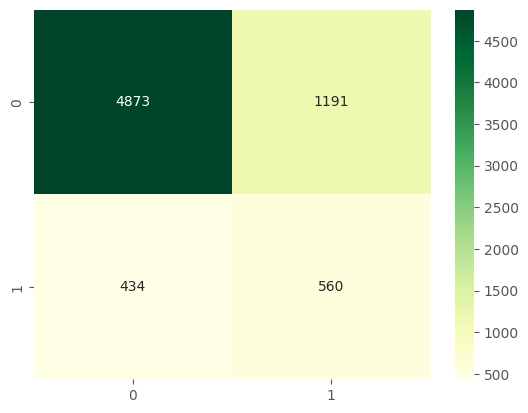

In [49]:
my_pred_dec_tree, my_dec_tree = my_decision_tree_model(X_rus, X_test, y_rus, y_test, 'entropy', 3, 5)


In [50]:
my_dec_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Random Forest

In [51]:
def my_random_forest_model(X_train, X_test, y_train, y_test, tree_num, depth = 5, leaf=5):

    # Create the model with 100 trees
    forest_model = RandomForestClassifier(n_estimators=tree_num, 
                                class_weight = 'balanced',
                                random_state=123, 
                                max_features = 'sqrt',
                                max_depth = depth,
                                min_samples_leaf = leaf,
                                n_jobs=-1, verbose = 1)

    # Fit on training data
    forest_model.fit(X_train, y_train)
    y_pred = forest_model.predict(X_test) 

    n_nodes = []
    max_depths = []

    # Stats about the trees in random forest
    for tree_idx in forest_model.estimators_:
        n_nodes.append(tree_idx.tree_.node_count)
        max_depths.append(tree_idx.tree_.max_depth)
    
    print('Info Random Forest Model')
    print('---'*15)
    print(f'Average number of nodes {int(np.mean(n_nodes))}')
    print(f'Average maximum depth {int(np.mean(max_depths))}')

   
   

    accuracy = (round(accuracy_score(y_test, y_pred),2))
    precision =  (round(precision_score(y_test, y_pred),2))
    recall =  (round(recall_score(y_test, y_pred),2))
    mae =  (round(mean_absolute_error(y_test, y_pred),2))
    print('Metrics Random Forest Model')
    print('---'*15)
    #print('Confusion Matrix: ')
    #print(confusion_matrix(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn',fmt=".0f")
    #ConfusionMatrixDisplay.from_estimator(dec_tree, X_test, y_test, cmap= 'YlGn')
    print(f'Accuracy - Test: {accuracy} - Train: {(round(accuracy_score(y_train, forest_model.predict(X_train)),2))}')
    print(f'Precision (TP/(TP+FP)) - Test:  {precision} - Train: {(round(precision_score(y_train, forest_model.predict(X_train)),2))}')
    print(f'Recall (TP/(TP+FN)) - Test:  {recall} - Train: {(round(recall_score(y_train, forest_model.predict(X_train)),2))}')
    print(f'MAE - Test:  {mae}  - Train: {(round(mean_absolute_error(y_train, forest_model.predict(X_train)),2))}')
    #ConfusionMatrixDisplay.from_estimator(dec_tree, X_test, y_test, normalize='all', cmap= 'YlGn')
    
    
    return(y_pred, forest_model)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

Info Random Forest Model
---------------------------------------------
Average number of nodes 55
Average maximum depth 5
Metrics Random Forest Model
---------------------------------------------
Accuracy - Test: 0.73 - Train: 0.75
Precision (TP/(TP+FP)) - Test:  0.31 - Train: 0.74
Recall (TP/(TP+FN)) - Test:  0.77 - Train: 0.77
MAE - Test:  0.27  - Train: 0.25


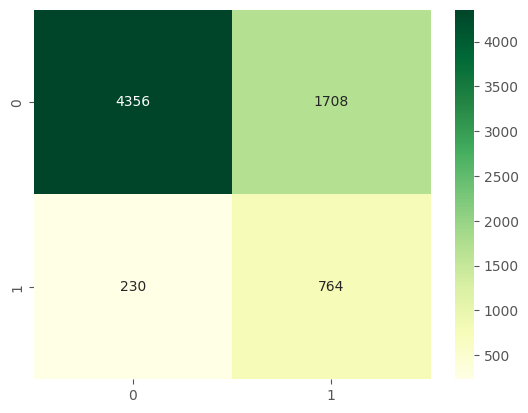

In [52]:
my_pred_forest_model, my_forest_model = my_random_forest_model(X_rus, X_test, y_rus, y_test, 100, 5, 5)

In [53]:
my_forest_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 1,
 'warm_start': False}

Test - different features  

Feature importance (Tree)

In [54]:

et_clf = ExtraTreesClassifier(n_estimators=50)
et_clf = et_clf.fit(X_rus, y_rus)
feature_importances = et_clf.feature_importances_  
fi_lst = []
for idx, i in enumerate(selected_features):
    fi_lst.append({'feature_name': i, 'feature_importance': feature_importances[idx]})
    #print(i, feature_importances[idx])
feature_df = pd.DataFrame(fi_lst) 
feature_df.sort_values('feature_importance')  

,feature_name,feature_importance
5,gender_of_respondent,0.026141
1,Urban_location,0.033667
6,relationship_with_head,0.045094
7,marital_status,0.047533
0,country,0.086051
2,cellphone_access,0.110548
9,job_type,0.119964
8,education_level,0.123898
3,household_size,0.131127
4,age_of_respondent,0.275976


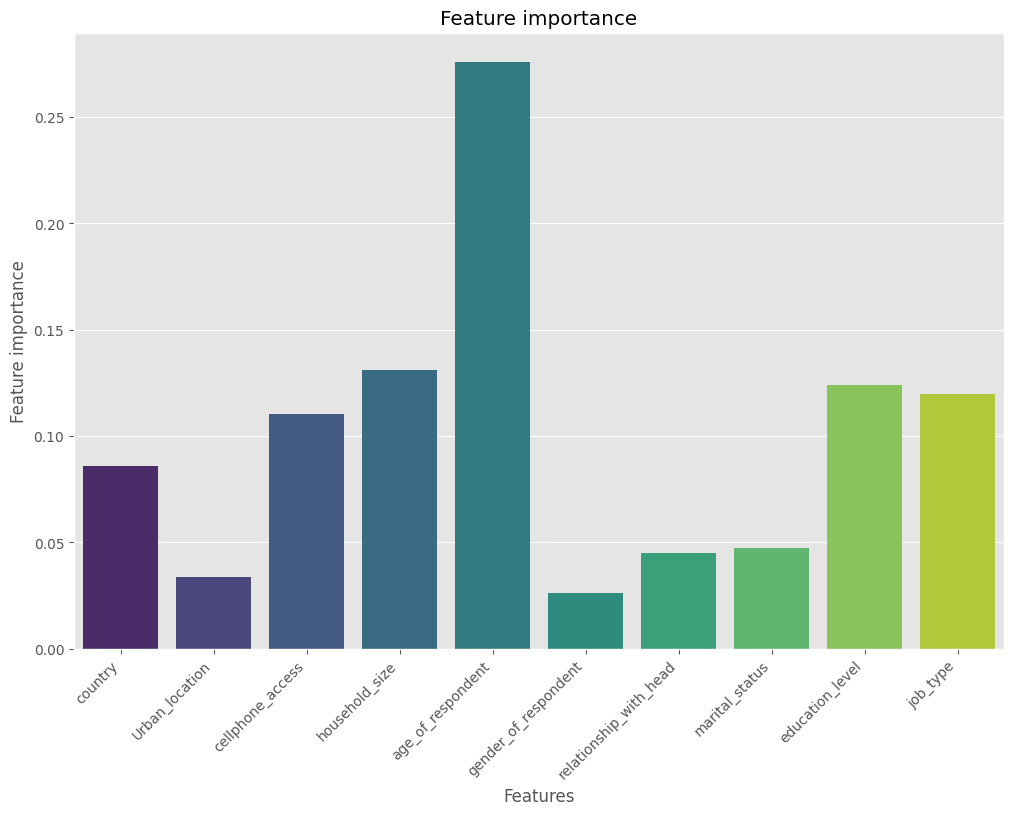

In [55]:
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_df['feature_name'],
            y=feature_df['feature_importance'].sort_values(ascending=False),
            palette="viridis")
plt.title('Feature importance')
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.xticks(rotation=45, ha="right")
plt.show()

In [56]:
feature_list = feature_df.sort_values('feature_importance').feature_name.to_list()
feature_list

['gender_of_respondent',
 'Urban_location',
 'relationship_with_head',
 'marital_status',
 'country',
 'cellphone_access',
 'job_type',
 'education_level',
 'household_size',
 'age_of_respondent']

In [57]:
def decision_tree_model(X_train, X_test, y_train, y_test, mycriterion = "gini", depth = 5, leaf=5): 
      
    # Creating the classifier object
    dec_tree = DecisionTreeClassifier(
            class_weight = 'balanced',
            criterion = mycriterion, 
            max_depth = depth, 
            min_samples_leaf = leaf
            ) 
    
    #class_weight = {0:0.58, 1:3.55},

    # Performing training 
    dec_tree.fit(X_train, y_train) 
    y_pred = dec_tree.predict(X_test) 

    accuracy = (round(accuracy_score(y_test, y_pred),2))
    precision =  (round(precision_score(y_test, y_pred),2))
    recall =  (round(recall_score(y_test, y_pred),2))
    mae =  (round(mean_absolute_error(y_test, y_pred),2))
    
    return(accuracy,precision,recall,mae)
   

In [58]:
selected_features = ['country', 'Urban_location', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type']

In [59]:
metrics_lst = []
for item in feature_list:
    X_loop = df[selected_features]
    y_loop = df['bank_account']
    # Train-Test-Split
    X_loop_train, X_loop_test, y_loop_train, y_loop_test = train_test_split(X_loop, y_loop,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    stratify=y_loop)
    rus = RandomUnderSampler(random_state=42)
    #fit predictor and target variable
    X_loop_rus, y_loop_rus = rus.fit_resample(X_loop,y_loop) # Resample the dataset
    accuracy_loop,precision_loop,recall_loop,mae_loop =decision_tree_model(X_loop_rus, X_loop_test, y_loop_rus, y_loop_test)
    metrics_lst.append({'del_feature': item,
                      'accuracy': accuracy_loop,
                      'precision':precision_loop,
                      'recall': recall_loop,
                      'mae':mae_loop})
    selected_features.remove(item)

metrics_df = pd.DataFrame(metrics_lst)
metrics_df

,del_feature,accuracy,precision,recall,mae
0,gender_of_respondent,0.76,0.33,0.67,0.24
1,Urban_location,0.76,0.33,0.67,0.24
2,relationship_with_head,0.77,0.34,0.65,0.23
3,marital_status,0.77,0.34,0.65,0.23
4,country,0.77,0.34,0.65,0.23
5,cellphone_access,0.73,0.30,0.73,0.27
6,job_type,0.83,0.42,0.60,0.17
7,education_level,0.83,0.43,0.59,0.17
8,household_size,0.49,0.17,0.67,0.51
9,age_of_respondent,0.38,0.16,0.82,0.62


In [60]:
selected_features

[]

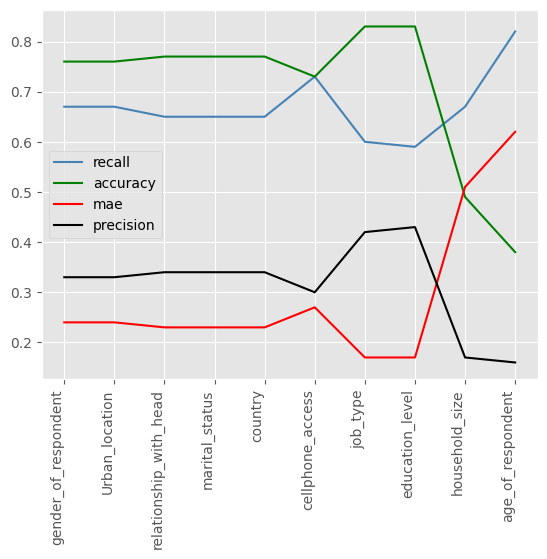

In [61]:
# Plotting 
plt.style.use('ggplot') 

plt.plot(metrics_df.del_feature, metrics_df.recall,c="steelblue", label="recall")
plt.plot(metrics_df.del_feature, metrics_df.accuracy,c="green", label="accuracy")
plt.plot(metrics_df.del_feature, metrics_df.mae,c="red", label="mae")
plt.plot(metrics_df.del_feature, metrics_df.precision,c="black", label="precision")
plt.xticks(rotation=90, ha="right")
plt.legend()

plt.show();

In [62]:
feature_df.sort_values('feature_importance')  

,feature_name,feature_importance
5,gender_of_respondent,0.026141
1,Urban_location,0.033667
6,relationship_with_head,0.045094
7,marital_status,0.047533
0,country,0.086051
2,cellphone_access,0.110548
9,job_type,0.119964
8,education_level,0.123898
3,household_size,0.131127
4,age_of_respondent,0.275976
